<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/09/0913.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!wget -O 0913_class.csv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/0913_class.csv?raw=1
!wget -O 0913_zoo.csv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/0913_zoo.csv?raw=1
!wget -O funcs.py https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/09/0913_funcs.py?raw=1

## Agglomerative clustering with categorical data


In [ ]:
# Zoo dataset : https://www.kaggle.com/datasets/uciml/zoo-animal-classification/code?datasetId=586&searchQuery=hier&select=zoo.csv

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from funcs import plot_cluster_dendrogram, cophenetic_corr

sns.set_theme()

## Animal zoo dataset

The Zoo Dataset is a comprehensive collection of data about various animals found in zoos worldwide. The dataset is composed of several attributes related to these animals, such as:

- `animal_name`: The name of the animal.

- `hair`: Indicates if the animal has hair (1 for yes, 0 for no).
- `feathers`: Indicates if the animal has feathers (1 for yes, 0 for no).
- `eggs`: Indicates if the animal lays eggs (1 for yes, 0 for no).
- `milk`: Indicates if the animal produces milk (1 for yes, 0 for no).
- `airborne`: Indicates if the animal can fly (1 for yes, 0 for no).
- `aquatic`: Indicates if the animal lives in water (1 for yes, 0 for no).
- `predator`: Indicates if the animal is a predator (1 for yes, 0 for no).
- `toothed`: Indicates if the animal has teeth (1 for yes, 0 for no).
- `backbone`: Indicates if the animal has a backbone (1 for yes, 0 for no).
- `breathes`: Indicates if the animal breathes air (1 for yes, 0 for no).
- `venomous`: Indicates if the animal is venomous (1 for yes, 0 for no).
- `fins`: Indicates if the animal has fins (1 for yes, 0 for no).
- `legs`: Number of legs the animal has (integer value).
- `tail`: Indicates if the animal has a tail (1 for yes, 0 for no).
- `domestic`: Indicates if the animal is domesticated (1 for yes, 0 for no).
- `catsize`: Indicates if the animal is cat-sized or larger (1 for yes, 0 for no).
- `class_type`: Numerical code indicating the animal's taxonomic class.


Citation : Forsyth,Richard. (1990). Zoo. UCI Machine Learning Repository. https://doi.org/10.24432/C5R59V.

In [ ]:
# in this demo, our goal will be to cluster the animals based on their characteristics
# and to see if we will manage to split animals into classes by using their characteristics

# Load the data
zoo_path = '0913_zoo.csv'
zoo_df = pd.read_csv(zoo_path)

# Load class mapping
class_mappings = '0913_class.csv'
class_mapper = pd.read_csv(class_mappings)

In [ ]:
zoo_df.head()
# all the categorical features are already ordinaly encoded

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [ ]:
class_mapper
# metadata
# Class_Number: class id
# Class_Type: class name

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


In [ ]:
zoo_df.shape

(101, 18)

In [ ]:
zoo_df.isna().sum(axis=0)
# we do not have a missing values

,0
animal_name,0
hair,0
feathers,0
eggs,0
milk,0
airborne,0
aquatic,0
predator,0
toothed,0
backbone,0


In [ ]:
# Check number of unique animals
zoo_df['animal_name'].nunique()
# some names are duplicated

100

In [ ]:
# Drop duplicates since there should be one species per row
zoo_df = zoo_df.drop_duplicates('animal_name')
zoo_df.shape

(100, 18)

In [ ]:
# Map class id to class name
class_map_dict = class_mapper.set_index('Class_Number')['Class_Type'].to_dict()
zoo_df['class_type'] = zoo_df['class_type'].map(class_map_dict)

# Extract class as separate object and drop class from zoo_df
animal_class = zoo_df['class_type']
zoo_df = zoo_df.drop(columns=['class_type'])

In [ ]:
# Set animal name as index
zoo_df = zoo_df.set_index('animal_name', drop=True)

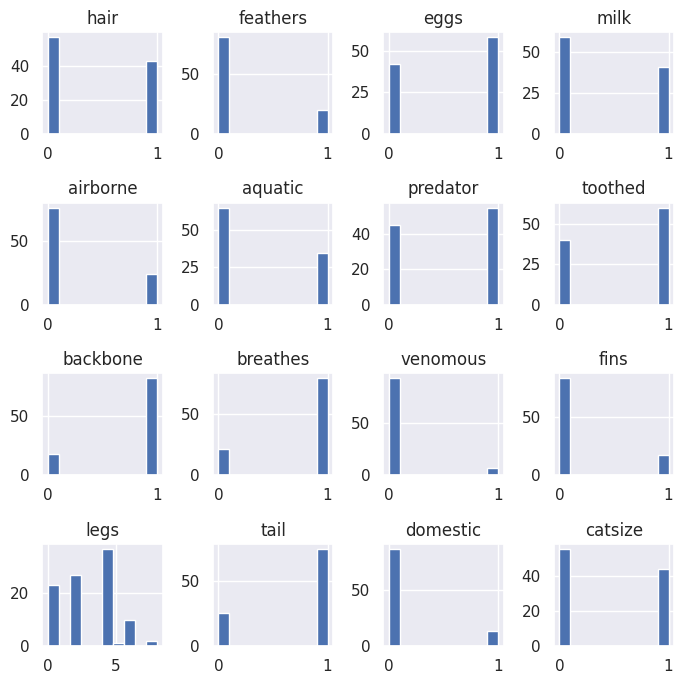

In [ ]:
_ = zoo_df.hist(figsize=(7,7))
plt.tight_layout()
# we can see the distribution of values in our categorical features
# majority of features is binary (except "legs")

### Agglomerative clustering with hamming distance

In [ ]:
linkage_matrix = linkage(
    zoo_df.to_numpy(),
    method='average',
    metric='hamming'
)

In [ ]:
cophenetic_corr(
    linkage_matrix=linkage_matrix,
    data_mtx = zoo_df.to_numpy(),
    distance_measure='hamming'
)
# the dendrogram is a good representative of our data

Cophenetic correlation : 0.8584617992386253


In [ ]:
linkage_matrix[:,2] += 0.001
# trick, in this data set, Hamming distance will turn out to be 0,
# which can be problematic when displaying the data on the dendrogram,
# so we will add small constants to all the distances

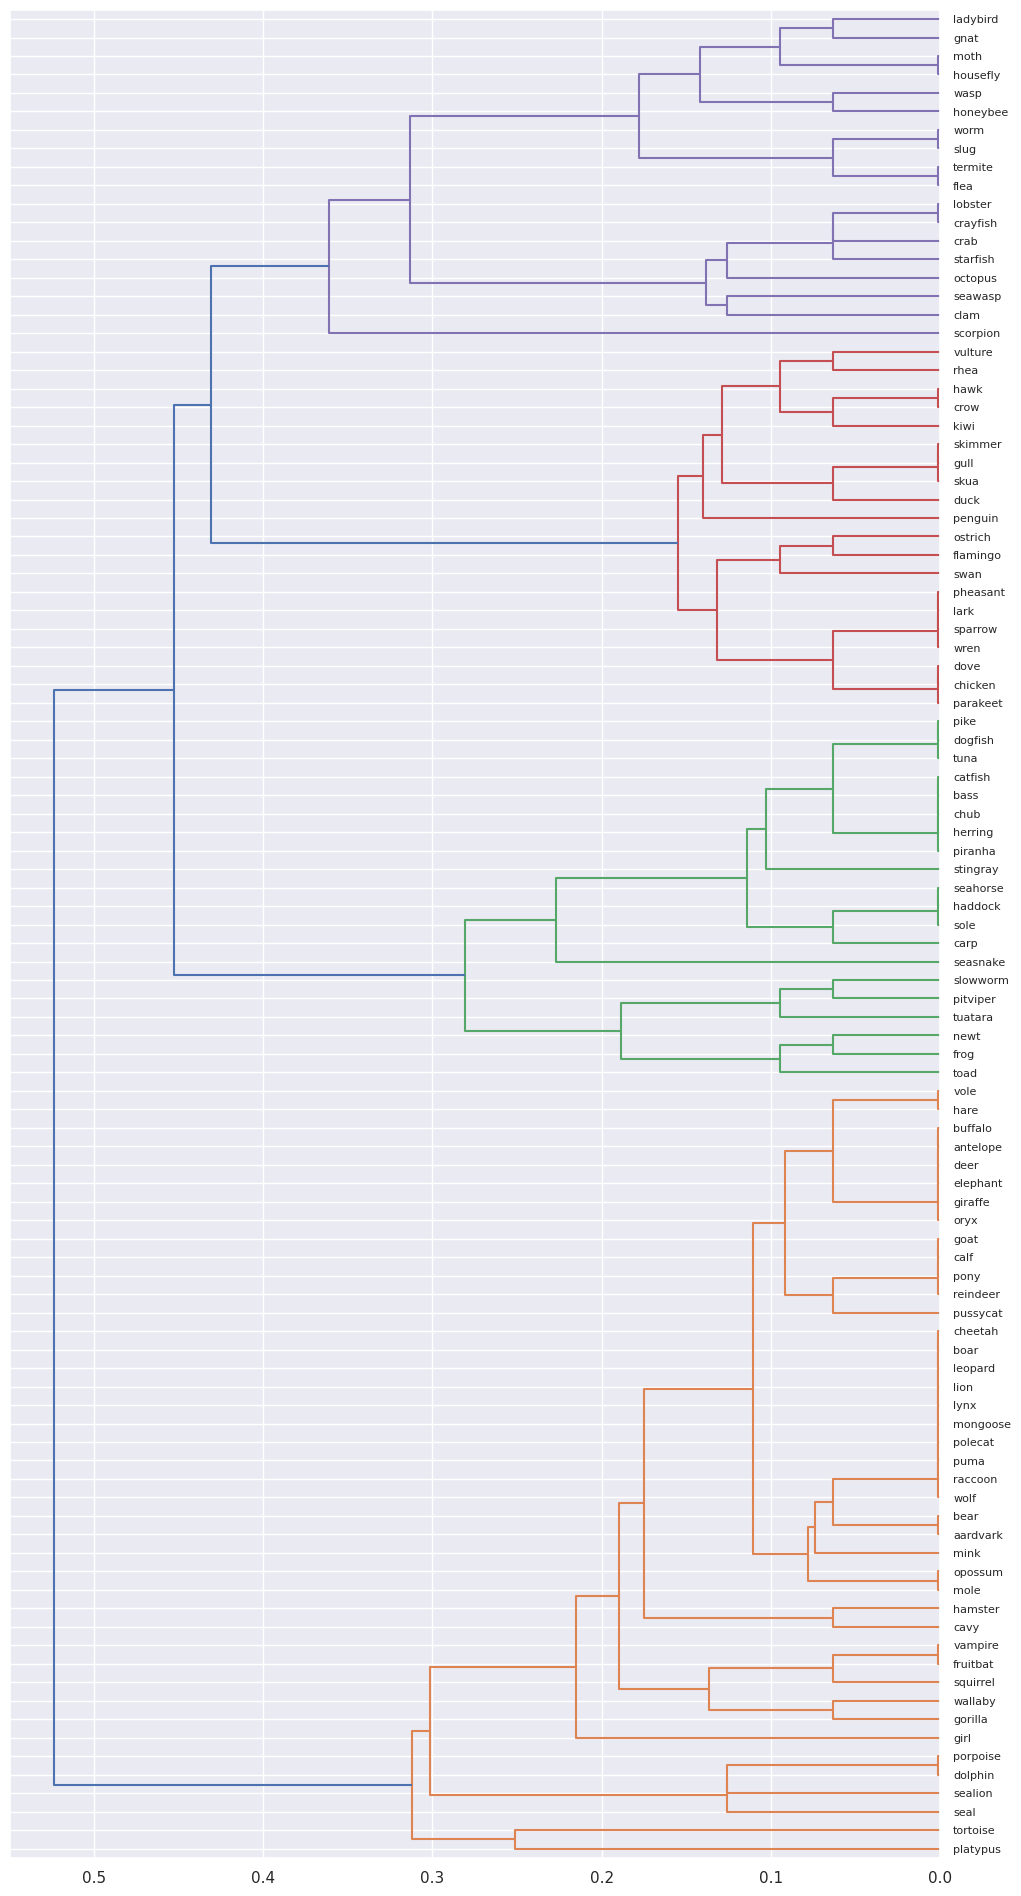

In [ ]:
plt.rcParams['figure.figsize'] = [12, 24]
_ = dendrogram(
    linkage_matrix,
    labels=zoo_df.index,
    orientation='left',
    leaf_font_size=8
)
# we have all kinds of groups and subgroups describing relationships between our animals

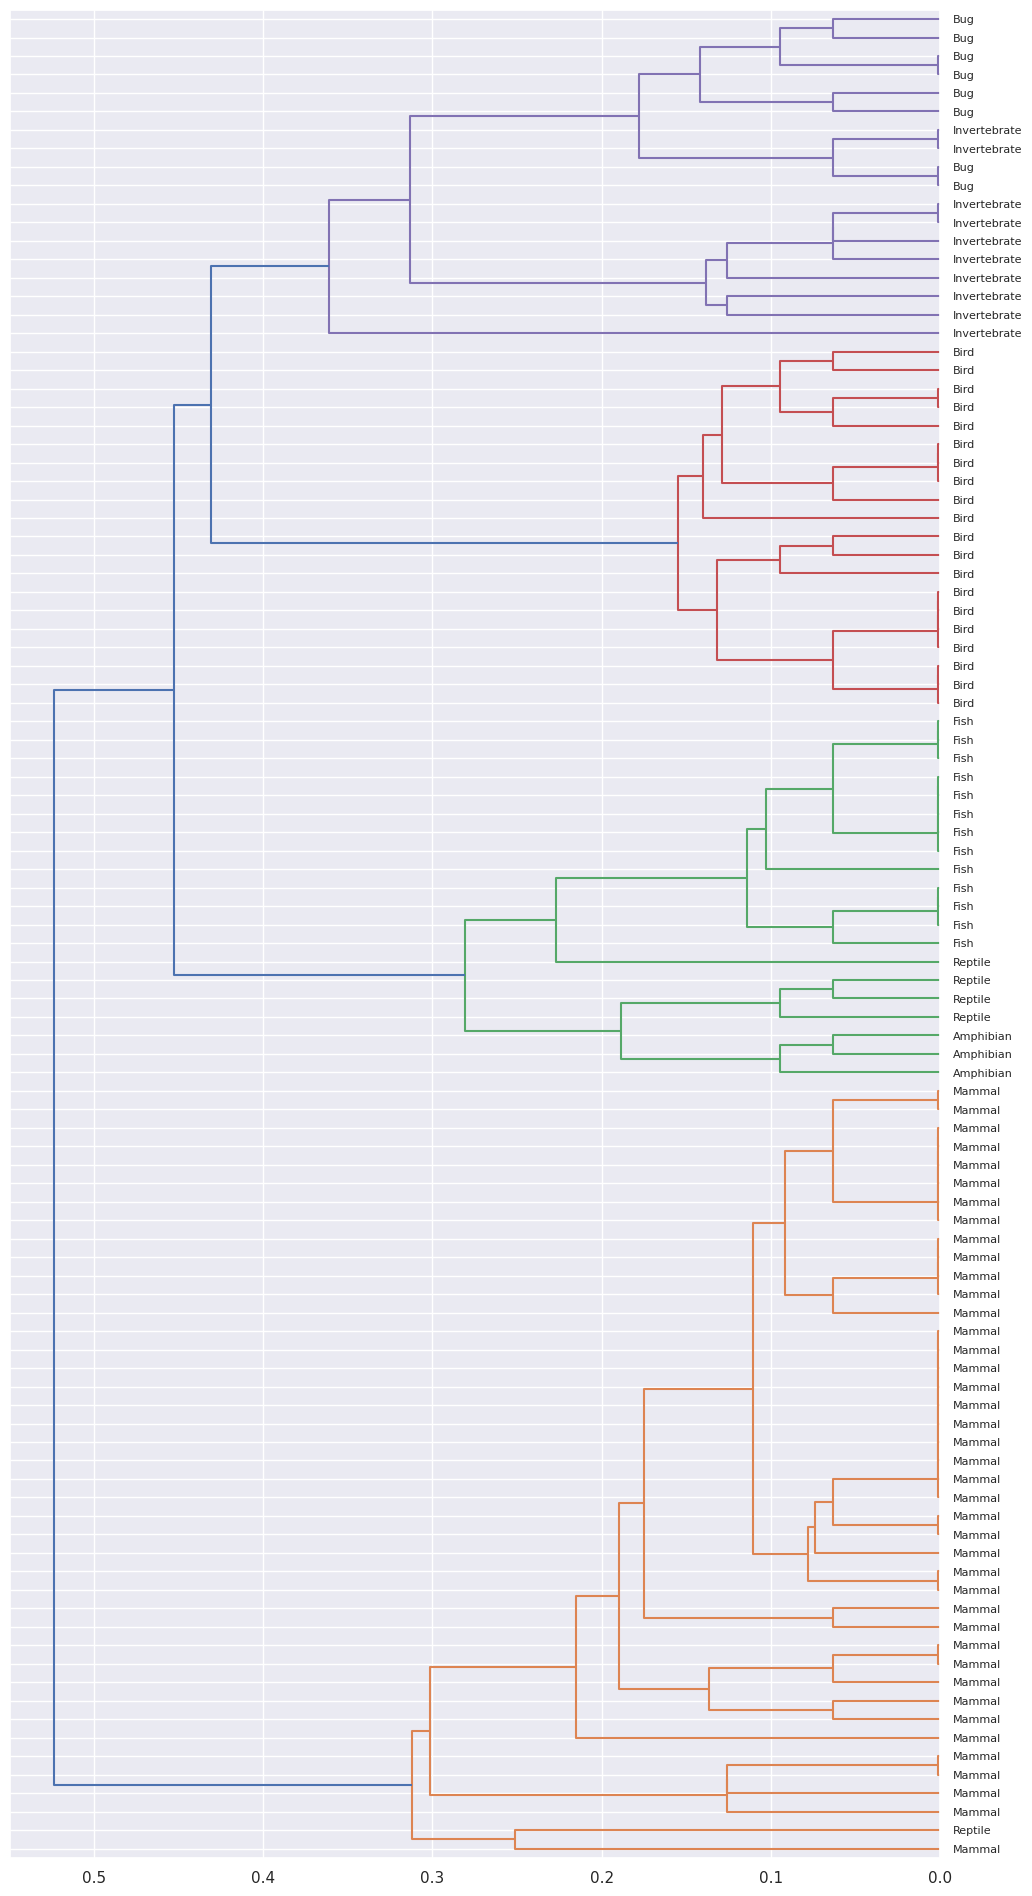

In [ ]:
plt.rcParams['figure.figsize'] = [12, 24]
_ = dendrogram(
    linkage_matrix,
    labels=animal_class.to_numpy(),
    orientation='left',
    leaf_font_size=8
)
# this dendrogram successfully manages to separate different animal classes
# and also gives us relationship between different classes

In [ ]:
# Perform clustering
clusters = fcluster(Z=linkage_matrix, t=0.28, criterion='distance')
clusters

array([3, 3, 5, 3, 3, 3, 3, 5, 5, 3, 3, 6, 5, 7, 7, 7, 6, 3, 5, 2, 6, 6,
       3, 6, 8, 4, 3, 3, 3, 8, 3, 3, 6, 5, 3, 3, 6, 5, 8, 8, 6, 8, 6, 3,
       3, 7, 3, 3, 3, 3, 8, 4, 7, 3, 3, 6, 6, 6, 6, 5, 5, 4, 1, 3, 3, 2,
       3, 3, 3, 3, 6, 9, 5, 2, 2, 5, 7, 6, 6, 4, 8, 5, 6, 3, 7, 5, 6, 8,
       4, 1, 4, 5, 3, 3, 6, 3, 8, 3, 8, 6], dtype=int32)

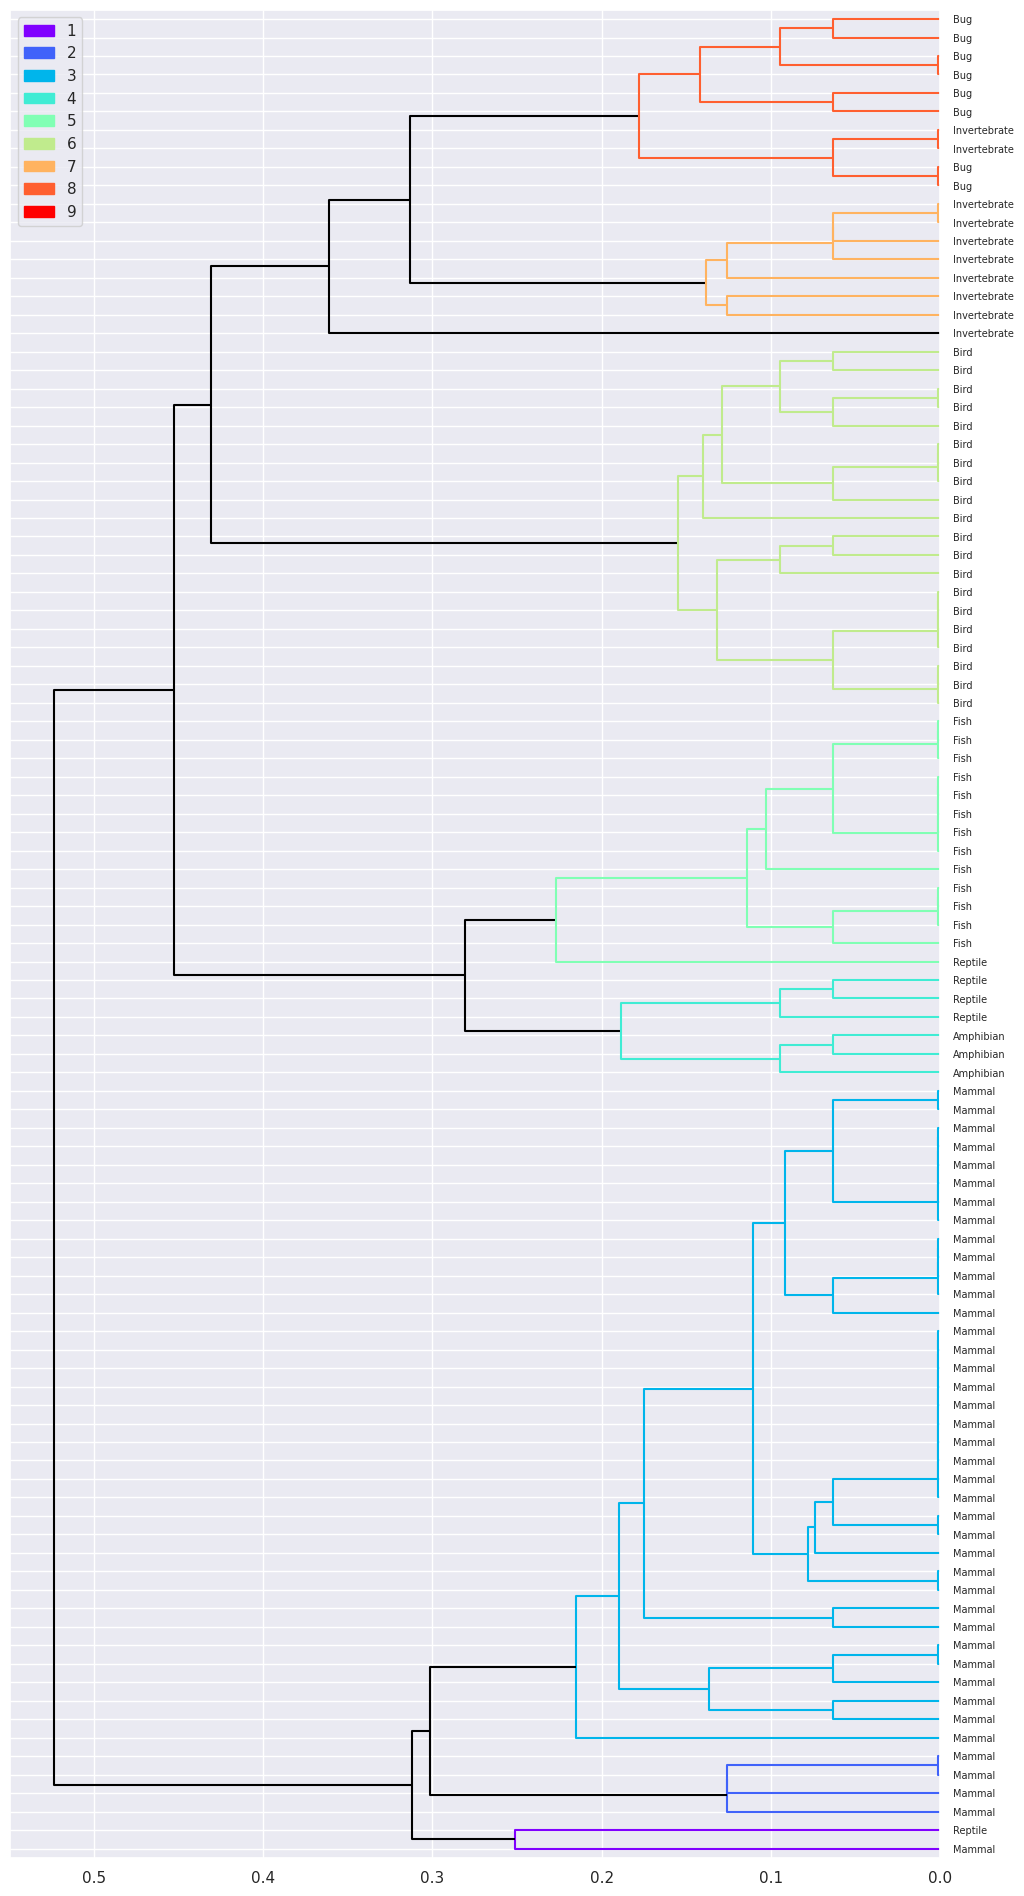

In [ ]:
_ = plot_cluster_dendrogram(
    linkage_matrix=linkage_matrix,
    dataset_df=zoo_df,
    clusters=clusters,
    leaf_font_size=7,
    labels=animal_class.to_numpy()
)
# we have clusters containing different animal types
# we have clusters that are a bit weird
# so here we have a reptile and a mammal together
# and we have a group of mammals that is different compared to the others

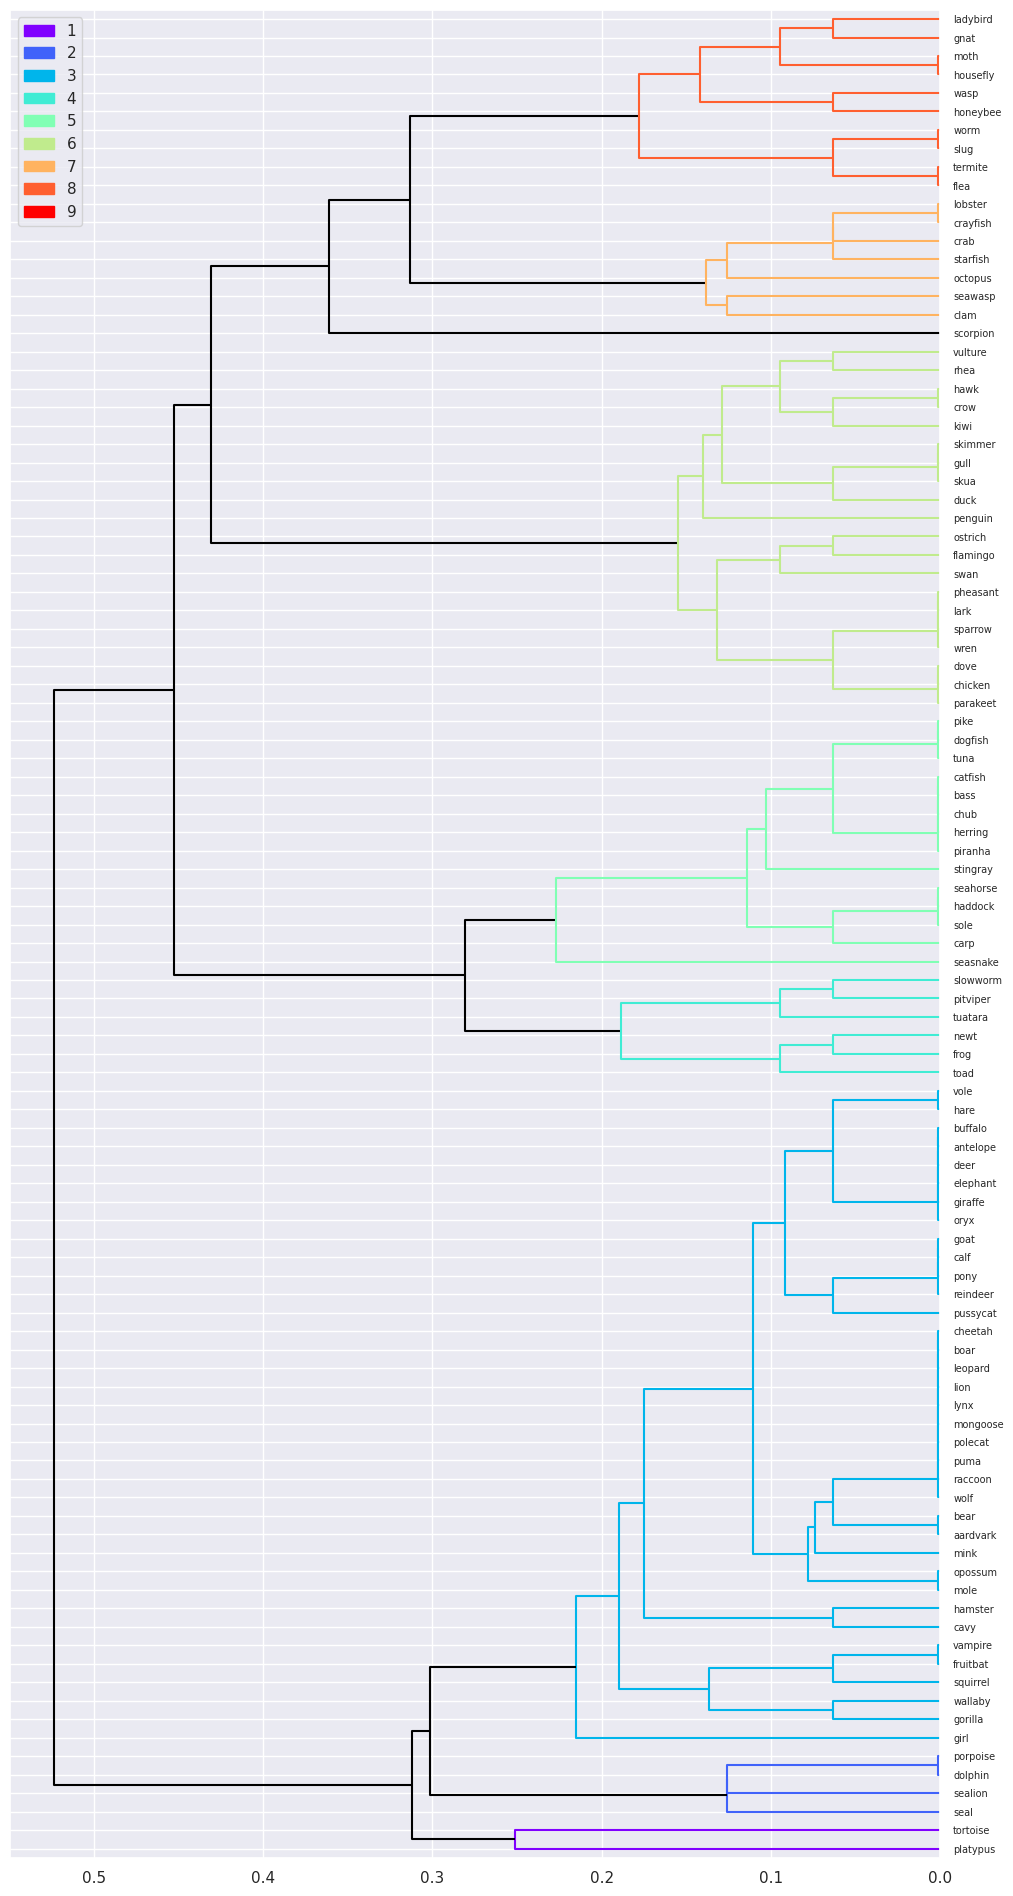

In [ ]:
_ = plot_cluster_dendrogram(
    linkage_matrix=linkage_matrix,
    dataset_df=zoo_df,
    clusters=clusters,
    leaf_font_size=7
)
# let's explore this
# we have a mammals that live in water
# and also we have this group containing a turtle and a platypus which have similar characteristics despite belonging to different animal classes